# Quantum Channel for the Ancilla Density Matrix in Random Unitary Circuit

![](RUC.png)

We are going to evaluate the effect of the matrices along the diagonal slice on the ancilla density matrix. After summing over the indices $(s_1,s_2)$ for a neighbouring pair of sites we lose the final layer by unitarity, and we are left with:

![](MPO.png)

The input ancilla density matrix $\rho_{a_1a_2a_3,\bar a_1\bar a_2 \bar a_3}$ will be contracted in at the bottom, and the indices of the output matrix $\rho'_{b_1b_2b_3,\bar b_1\bar b_2 \bar b_3}$ will pop out of the top. The task is to evaluate $\rho'$ for a given assignment of indices $b_j$ if all components of $\rho$ are known.

The first thing to notice is that the final index is traced over, lowering the dimension of the density matrix before we start. We then work from the [middle out](https://www.youtube.com/watch?v=0rhdOt9bOHE), contracting in a $U$ and $\bar U$ at each step. This is an $O(N^2)$ operation, where $N=q^d$ for depth $d$.

In [2]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

In [3]:
from ruc import (cptp_map, apply_gates, tensor_trace, trace_square, matrix_to_tensor, 
                        tensor_to_matrix, random_ρ, random_gates, random_state, inner_product)

## Einsum path optimization

In [9]:
q = 2
depth = 3
gates = random_gates(q, depth)
ρ = random_ρ(q, depth)
path = np.einsum_path('aACx,bBCy,ab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [10]:
print(path[0])

['einsum_path', (0, 1), (0, 1)]


In [11]:
print(path[1])

  Complete contraction:  aACx,bBCy,abkrnY->ABkrnYxy
         Naive scaling:  11
     Optimized scaling:  10
      Naive FLOP count:  6.144e+03
  Optimized FLOP count:  2.305e+03
   Theoretical speedup:  2.666
  Largest intermediate:  2.560e+02 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           bBCy,aACx->ABabxy                  abkrnY,ABabxy->ABkrnYxy
  10     ABabxy,abkrnY->ABkrnYxy                       ABkrnYxy->ABkrnYxy


In [12]:
path = np.einsum_path('aACx,bBDy,CDab...->AB...xy', gates[0], gates[0].conj(), ρ, optimize='greedy')

In [13]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [14]:
print(path[1])

  Complete contraction:  aACx,bBDy,CDabnY->ABnYxy
         Naive scaling:  10
     Optimized scaling:  8
      Naive FLOP count:  3.072e+03
  Optimized FLOP count:  1.025e+03
   Theoretical speedup:  2.997
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   8         CDabnY,aACx->ADYbnx                      bBDy,ADYbnx->ABnYxy
   8         ADYbnx,bBDy->ABnYxy                           ABnYxy->ABnYxy


In [15]:
path = np.einsum_path('Cx,Dy,CD...->...xy', gates[-1][0, 0], gates[-1][0, 0].conj(), ρ, optimize=True)

In [16]:
print(path[0])

['einsum_path', (0, 2), (0, 1)]


In [17]:
print(path[1])

  Complete contraction:  Cx,Dy,CDrbnY->rbnYxy
         Naive scaling:  8
     Optimized scaling:  7
      Naive FLOP count:  7.680e+02
  Optimized FLOP count:  5.130e+02
   Theoretical speedup:  1.497
  Largest intermediate:  6.400e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   7           CDrbnY,Cx->DYbnrx                        Dy,DYbnrx->rbnYxy
   7           DYbnrx,Dy->rbnYxy                           rbnYxy->rbnYxy


## Complexity

In [12]:
timeit_results = []
q = 2
depths =  np.arange(5,13)
for d in depths:
    res = %timeit -o cptp_map(random_ρ(q, d), random_gates(q, d))
    timeit_results.append(res.average)

1.82 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.74 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.36 ms ± 72.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.4 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.6 ms ± 8.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
337 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.88 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.3 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the $4^d$ scaling

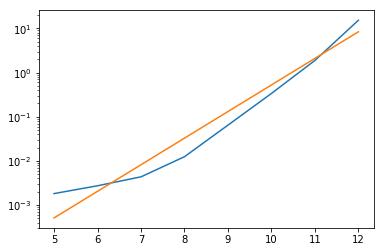

In [13]:
plt.semilogy(depths, timeit_results, depths, 0.0000005*4**depths)

## CPTP map simulation

In [24]:
q = 2
depth = 10
# ρ = np.zeros(2*depth*[q])
# ρ[tuple(2*depth*[0])] = 1
ρ = random_ρ(q, depth)
purity_trace = np.array([])
eigenvalues = np.array([])

for step in range(1000):
    purity_trace = np.append(purity_trace, trace_square(ρ))
    eigenvalues = np.concatenate([eigenvalues, eigh(tensor_to_matrix(ρ), eigvals_only=True)])
    ρ = cptp_map(ρ, random_gates(q, depth))
    if step % 100 == 0:
        print("step ", step)

step  0
step  100
step  200
step  300
step  400
step  500
step  600
step  700
step  800
step  900


## Purity from CPTP map

In [25]:
np.mean(purity_trace)

(0.10936594607586003-8.323414668814054e-19j)

In [26]:
-np.log(np.mean(purity_trace))

(2.213055716465701+7.610609122368532e-18j)

In [27]:
-np.log((4/5)**10)

2.231435513142097

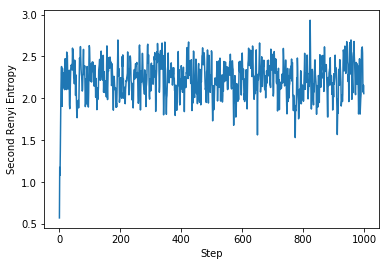

In [28]:
plt.plot(-np.log(np.real(purity_trace)))
plt.xlabel("Step")
plt.ylabel("Second Renyi Entropy");

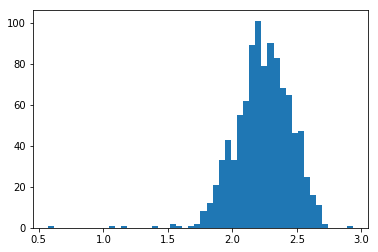

In [29]:
plt.hist(-np.log(np.real(purity_trace)), bins=50);

## Spectrum

/Users/austen/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


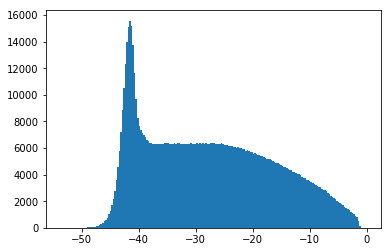

In [30]:
plt.hist(np.log(eigenvalues), bins=200);

Compare with fully random density matrix

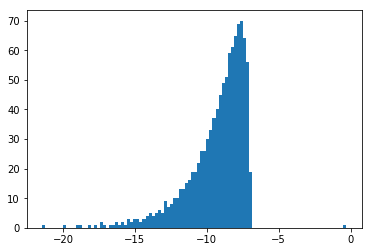

In [31]:
plt.hist(np.log(eigh(tensor_to_matrix(random_ρ(2, 10)), eigvals_only=True)), bins=100);

## Purity from Trajectories

Now we try it the second way using the relationship

$$
\gamma = \mathrm tr\left[\rho_A^2\right] = \mathbb{E}_{x_1:x_N,\atop y_1:y_N}|\langle\psi_{x_1:x_N}|\psi_{y_1:y_N}\rangle|^2
$$

where $|\psi_{x_1:x_N}\rangle$ represents a normalized ancilla state arising from the trajectory $x_1:x_N$, where each step of the trajetory consists of a pair $x_j=(x^{(1)}_j, x^{(2)}_{j})$, where $x^{(1,2)}_j\in 1,\ldots q$.

__Note__ that this way requires one extra unitary as we don't do the sum over $x_j$.

In [51]:
q = 2
depth = 10
state1 = random_state(q, depth)
state2 = state1
purity_traj = np.array([])

for step in range(10000):
    purity_traj = np.append(purity_trace, np.abs(inner_product(state1, state2))**2)
    gates = random_gates(q, depth + 1) # Need one more gate than in the CPTP case
    state1 = apply_gates(state1, gates)
    state2 = apply_gates(state2, gates)
    if step % 1000 == 0:
        print("step ", step)

step  0
step  1000
step  2000
step  3000
step  4000
step  5000
step  6000
step  7000
step  8000
step  9000


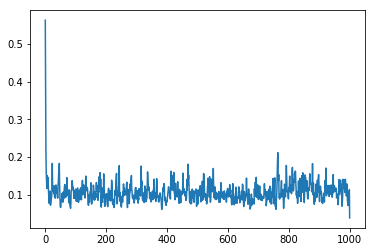

In [52]:
plt.plot(purity_traj)

In [53]:
np.mean(purity_traj)

(0.10626561493164043-2.1590314665381085e-19j)

In [54]:
(4/5)**10

0.10737418240000006